# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

#I am running this code on FloydHub
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

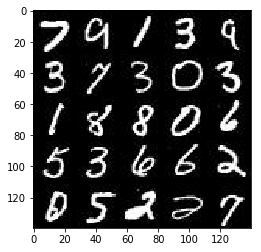

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

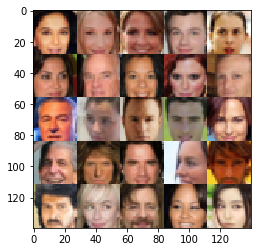

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        #flatten the output
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        #run flattened output through a fully-connected layer to produce final output
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
    
        fc = tf.layers.dense(z, 7*7*256)
        fc = tf.reshape(fc, (-1, 7, 7, 256))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        
        deconv2 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha*deconv2, deconv2)
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        deconv3 = tf.maximum(alpha*deconv3, deconv3)
        
        logits = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        #output is hyperbolic tangent of the logits
        output = tf.tanh(logits)        

    return output
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
     
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    print_every = 10
    n_images = 32
    
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:  
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 5.2832... Generator Loss: 0.2035
Epoch 0/2... Discriminator Loss: 1.4361... Generator Loss: 0.7787
Epoch 0/2... Discriminator Loss: 1.9427... Generator Loss: 0.3001
Epoch 0/2... Discriminator Loss: 1.7566... Generator Loss: 0.3646
Epoch 0/2... Discriminator Loss: 1.1923... Generator Loss: 1.4733
Epoch 0/2... Discriminator Loss: 1.7737... Generator Loss: 1.9418
Epoch 0/2... Discriminator Loss: 1.5139... Generator Loss: 1.6142
Epoch 0/2... Discriminator Loss: 1.2384... Generator Loss: 1.2819
Epoch 0/2... Discriminator Loss: 1.1629... Generator Loss: 0.8726
Epoch 0/2... Discriminator Loss: 1.2297... Generator Loss: 0.7965


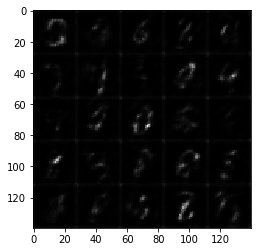

Epoch 0/2... Discriminator Loss: 1.3089... Generator Loss: 0.6128
Epoch 0/2... Discriminator Loss: 1.2057... Generator Loss: 1.5543
Epoch 0/2... Discriminator Loss: 1.0806... Generator Loss: 0.7826
Epoch 0/2... Discriminator Loss: 1.4500... Generator Loss: 2.4553
Epoch 0/2... Discriminator Loss: 1.0832... Generator Loss: 0.7957
Epoch 0/2... Discriminator Loss: 1.0459... Generator Loss: 1.9780
Epoch 0/2... Discriminator Loss: 0.9890... Generator Loss: 1.0508
Epoch 0/2... Discriminator Loss: 1.0357... Generator Loss: 0.8292
Epoch 0/2... Discriminator Loss: 1.4016... Generator Loss: 0.5299
Epoch 0/2... Discriminator Loss: 1.1883... Generator Loss: 0.6443


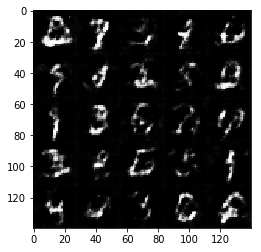

Epoch 0/2... Discriminator Loss: 1.2565... Generator Loss: 0.6527
Epoch 0/2... Discriminator Loss: 1.0241... Generator Loss: 1.0670
Epoch 0/2... Discriminator Loss: 1.2657... Generator Loss: 1.9180
Epoch 0/2... Discriminator Loss: 1.2529... Generator Loss: 0.5990
Epoch 0/2... Discriminator Loss: 1.5825... Generator Loss: 0.4168
Epoch 0/2... Discriminator Loss: 1.3180... Generator Loss: 1.6995
Epoch 0/2... Discriminator Loss: 1.2876... Generator Loss: 0.6122
Epoch 0/2... Discriminator Loss: 1.1434... Generator Loss: 1.0816
Epoch 0/2... Discriminator Loss: 0.9615... Generator Loss: 1.1617
Epoch 0/2... Discriminator Loss: 1.1516... Generator Loss: 1.0458


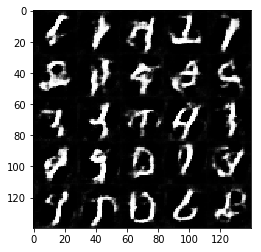

Epoch 0/2... Discriminator Loss: 0.9764... Generator Loss: 1.1063
Epoch 0/2... Discriminator Loss: 0.9906... Generator Loss: 1.2931
Epoch 0/2... Discriminator Loss: 1.2025... Generator Loss: 0.7437
Epoch 0/2... Discriminator Loss: 0.9414... Generator Loss: 1.2188
Epoch 0/2... Discriminator Loss: 1.1138... Generator Loss: 1.1713
Epoch 0/2... Discriminator Loss: 1.0100... Generator Loss: 1.2678
Epoch 0/2... Discriminator Loss: 1.4123... Generator Loss: 0.5277
Epoch 0/2... Discriminator Loss: 1.3363... Generator Loss: 0.5557
Epoch 0/2... Discriminator Loss: 0.9983... Generator Loss: 0.9511
Epoch 0/2... Discriminator Loss: 1.1589... Generator Loss: 0.7388


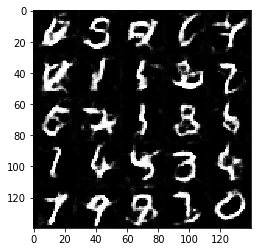

Epoch 0/2... Discriminator Loss: 0.9805... Generator Loss: 1.5587
Epoch 0/2... Discriminator Loss: 1.0766... Generator Loss: 0.9466
Epoch 0/2... Discriminator Loss: 1.0273... Generator Loss: 0.9032
Epoch 0/2... Discriminator Loss: 1.0531... Generator Loss: 1.5156
Epoch 0/2... Discriminator Loss: 1.4761... Generator Loss: 0.4586
Epoch 0/2... Discriminator Loss: 1.1388... Generator Loss: 0.9804
Epoch 0/2... Discriminator Loss: 1.0224... Generator Loss: 1.4048
Epoch 0/2... Discriminator Loss: 1.0472... Generator Loss: 0.8564
Epoch 0/2... Discriminator Loss: 1.0980... Generator Loss: 2.0804
Epoch 0/2... Discriminator Loss: 0.8803... Generator Loss: 1.2890


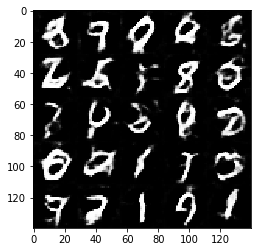

Epoch 0/2... Discriminator Loss: 1.0817... Generator Loss: 0.7928
Epoch 0/2... Discriminator Loss: 1.3971... Generator Loss: 0.5198
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 0.6448
Epoch 0/2... Discriminator Loss: 1.3767... Generator Loss: 0.5278
Epoch 0/2... Discriminator Loss: 1.0503... Generator Loss: 0.9454
Epoch 0/2... Discriminator Loss: 1.0206... Generator Loss: 0.8634
Epoch 0/2... Discriminator Loss: 1.0396... Generator Loss: 1.6498
Epoch 0/2... Discriminator Loss: 0.9110... Generator Loss: 1.6029
Epoch 0/2... Discriminator Loss: 1.0937... Generator Loss: 0.7535
Epoch 0/2... Discriminator Loss: 1.1525... Generator Loss: 0.7289


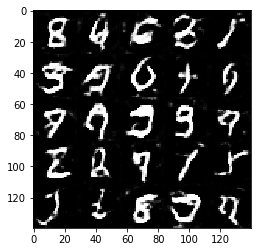

Epoch 0/2... Discriminator Loss: 0.7724... Generator Loss: 1.7373
Epoch 0/2... Discriminator Loss: 0.8322... Generator Loss: 1.2674
Epoch 0/2... Discriminator Loss: 1.2682... Generator Loss: 0.7355
Epoch 0/2... Discriminator Loss: 1.2207... Generator Loss: 0.6668
Epoch 0/2... Discriminator Loss: 0.9874... Generator Loss: 0.9874
Epoch 0/2... Discriminator Loss: 0.9023... Generator Loss: 1.1005
Epoch 0/2... Discriminator Loss: 1.3622... Generator Loss: 0.6182
Epoch 0/2... Discriminator Loss: 0.9328... Generator Loss: 1.3805
Epoch 0/2... Discriminator Loss: 1.0158... Generator Loss: 0.9525
Epoch 0/2... Discriminator Loss: 0.9095... Generator Loss: 1.0661


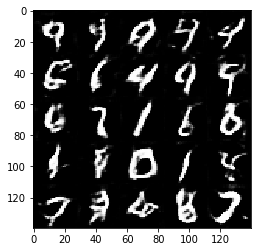

Epoch 0/2... Discriminator Loss: 1.0099... Generator Loss: 1.0252
Epoch 0/2... Discriminator Loss: 1.1613... Generator Loss: 0.7126
Epoch 0/2... Discriminator Loss: 0.9498... Generator Loss: 1.4155
Epoch 0/2... Discriminator Loss: 0.8363... Generator Loss: 1.3294
Epoch 0/2... Discriminator Loss: 0.7864... Generator Loss: 1.6868
Epoch 0/2... Discriminator Loss: 1.9663... Generator Loss: 3.0375
Epoch 0/2... Discriminator Loss: 1.0526... Generator Loss: 1.1113
Epoch 0/2... Discriminator Loss: 0.9296... Generator Loss: 1.3035
Epoch 0/2... Discriminator Loss: 1.2844... Generator Loss: 0.6196
Epoch 0/2... Discriminator Loss: 1.2857... Generator Loss: 0.5787


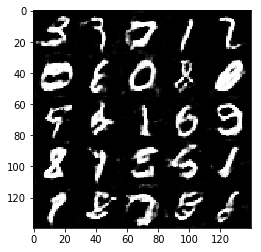

Epoch 0/2... Discriminator Loss: 0.9423... Generator Loss: 2.1961
Epoch 0/2... Discriminator Loss: 0.9581... Generator Loss: 1.1436
Epoch 0/2... Discriminator Loss: 0.8603... Generator Loss: 1.6363
Epoch 0/2... Discriminator Loss: 0.8509... Generator Loss: 1.3455
Epoch 0/2... Discriminator Loss: 1.0535... Generator Loss: 0.8217
Epoch 0/2... Discriminator Loss: 0.9259... Generator Loss: 0.9590
Epoch 0/2... Discriminator Loss: 0.6902... Generator Loss: 1.4380
Epoch 0/2... Discriminator Loss: 1.5939... Generator Loss: 0.4746
Epoch 0/2... Discriminator Loss: 0.8865... Generator Loss: 1.7361
Epoch 0/2... Discriminator Loss: 0.8305... Generator Loss: 1.3634


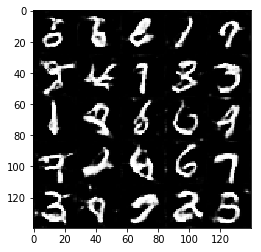

Epoch 0/2... Discriminator Loss: 1.0120... Generator Loss: 0.9186
Epoch 0/2... Discriminator Loss: 0.9790... Generator Loss: 0.9436
Epoch 0/2... Discriminator Loss: 0.6880... Generator Loss: 1.4542
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 0.8142... Generator Loss: 1.2168
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.7988
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.7343
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.7027


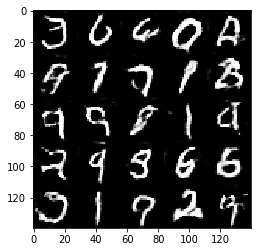

Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.9212
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.5345
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.6045... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 1.1896


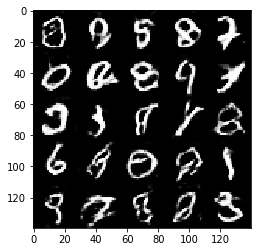

Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 1.3052
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.9118
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 2.0703
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 2.3118
Epoch 1/2... Discriminator Loss: 0.8485... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.8891


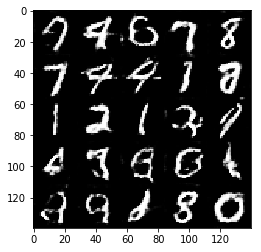

Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 5.2082
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.3337
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 0.8998
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 1.4842... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 0.9823


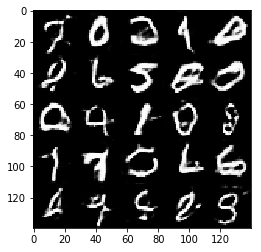

Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 1.6012
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 1.5947
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 2.7712
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.4182
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.2370
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 1.5247
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.4655
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 1.7007


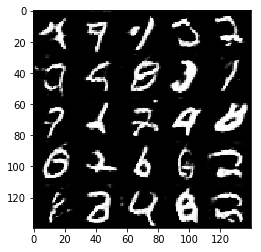

Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.6624
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 1.8301
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 0.4585... Generator Loss: 2.6164
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 1.3951
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 1.0502
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 2.0826


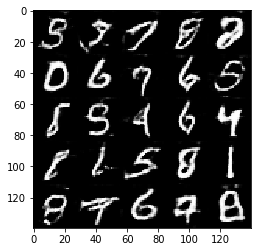

Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.9134
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 2.0059... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 0.9695... Generator Loss: 1.8274
Epoch 1/2... Discriminator Loss: 0.7860... Generator Loss: 1.8703


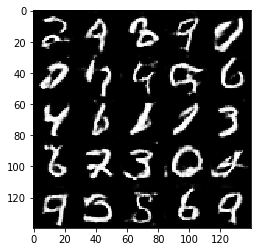

Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 2.5617
Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.7386
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 2.2169
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 0.5659... Generator Loss: 2.5606
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.8460
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 2.2200


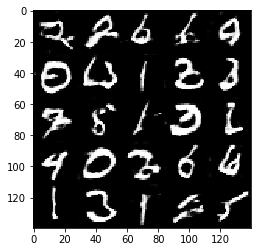

Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 1.7426
Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 0.6836... Generator Loss: 1.5763
Epoch 1/2... Discriminator Loss: 0.8137... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 0.9919
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 1.6871


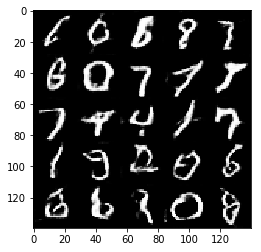

Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 2.1347
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 2.0522
Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 2.0743
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.0224


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.6184... Generator Loss: 6.2321
Epoch 0/1... Discriminator Loss: 1.8768... Generator Loss: 0.4740
Epoch 0/1... Discriminator Loss: 1.3625... Generator Loss: 0.7431
Epoch 0/1... Discriminator Loss: 1.1168... Generator Loss: 1.5885
Epoch 0/1... Discriminator Loss: 1.1533... Generator Loss: 1.8105
Epoch 0/1... Discriminator Loss: 3.0458... Generator Loss: 5.8804
Epoch 0/1... Discriminator Loss: 0.8510... Generator Loss: 1.6059
Epoch 0/1... Discriminator Loss: 1.5730... Generator Loss: 5.1105
Epoch 0/1... Discriminator Loss: 1.6439... Generator Loss: 4.0561
Epoch 0/1... Discriminator Loss: 0.9389... Generator Loss: 1.4026


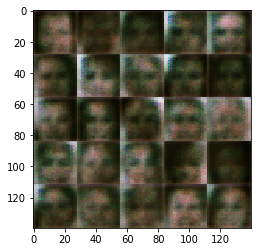

Epoch 0/1... Discriminator Loss: 2.2152... Generator Loss: 0.6291
Epoch 0/1... Discriminator Loss: 1.0226... Generator Loss: 1.9006
Epoch 0/1... Discriminator Loss: 1.2699... Generator Loss: 0.7142
Epoch 0/1... Discriminator Loss: 1.3327... Generator Loss: 0.7114
Epoch 0/1... Discriminator Loss: 0.9537... Generator Loss: 1.0568
Epoch 0/1... Discriminator Loss: 1.7616... Generator Loss: 0.4775
Epoch 0/1... Discriminator Loss: 1.3598... Generator Loss: 0.6254
Epoch 0/1... Discriminator Loss: 1.2116... Generator Loss: 0.7287
Epoch 0/1... Discriminator Loss: 0.8214... Generator Loss: 1.4662
Epoch 0/1... Discriminator Loss: 1.1206... Generator Loss: 1.1480


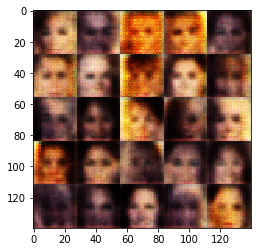

Epoch 0/1... Discriminator Loss: 1.3389... Generator Loss: 0.7208
Epoch 0/1... Discriminator Loss: 1.2651... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.5628... Generator Loss: 0.7933
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 1.1812... Generator Loss: 1.2217
Epoch 0/1... Discriminator Loss: 1.4905... Generator Loss: 2.9794
Epoch 0/1... Discriminator Loss: 1.2775... Generator Loss: 0.8065
Epoch 0/1... Discriminator Loss: 1.1797... Generator Loss: 0.8238
Epoch 0/1... Discriminator Loss: 1.0797... Generator Loss: 0.8570
Epoch 0/1... Discriminator Loss: 2.0486... Generator Loss: 0.2505


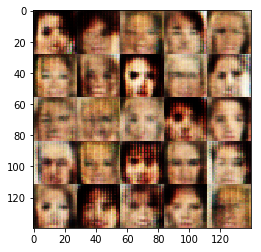

Epoch 0/1... Discriminator Loss: 1.2467... Generator Loss: 0.6533
Epoch 0/1... Discriminator Loss: 1.1949... Generator Loss: 0.9083
Epoch 0/1... Discriminator Loss: 2.1178... Generator Loss: 3.5778
Epoch 0/1... Discriminator Loss: 1.2278... Generator Loss: 1.0643
Epoch 0/1... Discriminator Loss: 1.1630... Generator Loss: 1.4766
Epoch 0/1... Discriminator Loss: 1.5074... Generator Loss: 1.5658
Epoch 0/1... Discriminator Loss: 0.9432... Generator Loss: 1.2298
Epoch 0/1... Discriminator Loss: 0.9201... Generator Loss: 1.0035
Epoch 0/1... Discriminator Loss: 1.1977... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.6386


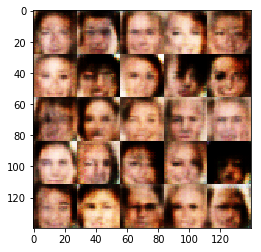

Epoch 0/1... Discriminator Loss: 1.4597... Generator Loss: 0.4842
Epoch 0/1... Discriminator Loss: 1.1480... Generator Loss: 0.7447
Epoch 0/1... Discriminator Loss: 1.1736... Generator Loss: 0.6174
Epoch 0/1... Discriminator Loss: 1.5962... Generator Loss: 1.1164
Epoch 0/1... Discriminator Loss: 1.3538... Generator Loss: 0.9903
Epoch 0/1... Discriminator Loss: 1.0452... Generator Loss: 0.8433
Epoch 0/1... Discriminator Loss: 1.2448... Generator Loss: 1.3803
Epoch 0/1... Discriminator Loss: 1.4598... Generator Loss: 0.5151
Epoch 0/1... Discriminator Loss: 1.4727... Generator Loss: 1.1242
Epoch 0/1... Discriminator Loss: 1.2719... Generator Loss: 0.9366


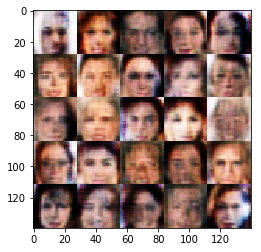

Epoch 0/1... Discriminator Loss: 1.8696... Generator Loss: 0.3039
Epoch 0/1... Discriminator Loss: 1.1100... Generator Loss: 0.8958
Epoch 0/1... Discriminator Loss: 1.0635... Generator Loss: 0.9606
Epoch 0/1... Discriminator Loss: 1.7066... Generator Loss: 1.6383
Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 1.0020
Epoch 0/1... Discriminator Loss: 1.4020... Generator Loss: 0.6631
Epoch 0/1... Discriminator Loss: 1.1290... Generator Loss: 1.1074
Epoch 0/1... Discriminator Loss: 1.2704... Generator Loss: 0.8093
Epoch 0/1... Discriminator Loss: 1.3282... Generator Loss: 0.7714
Epoch 0/1... Discriminator Loss: 1.5123... Generator Loss: 0.5175


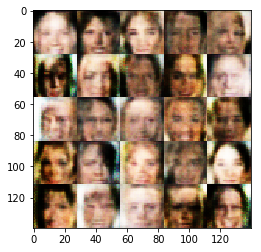

Epoch 0/1... Discriminator Loss: 1.0614... Generator Loss: 1.2956
Epoch 0/1... Discriminator Loss: 1.2779... Generator Loss: 0.6405
Epoch 0/1... Discriminator Loss: 1.1508... Generator Loss: 0.9256
Epoch 0/1... Discriminator Loss: 1.3617... Generator Loss: 1.1398
Epoch 0/1... Discriminator Loss: 1.1468... Generator Loss: 1.7797
Epoch 0/1... Discriminator Loss: 1.3057... Generator Loss: 1.1234
Epoch 0/1... Discriminator Loss: 1.2878... Generator Loss: 0.7083
Epoch 0/1... Discriminator Loss: 0.9581... Generator Loss: 0.9144
Epoch 0/1... Discriminator Loss: 1.5368... Generator Loss: 1.0678
Epoch 0/1... Discriminator Loss: 1.2070... Generator Loss: 0.9022


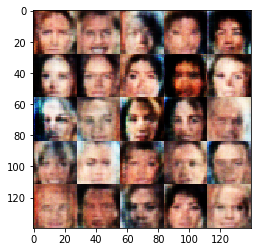

Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.9516
Epoch 0/1... Discriminator Loss: 1.3703... Generator Loss: 0.8795
Epoch 0/1... Discriminator Loss: 1.3575... Generator Loss: 0.7525
Epoch 0/1... Discriminator Loss: 1.2723... Generator Loss: 0.7250
Epoch 0/1... Discriminator Loss: 1.2146... Generator Loss: 0.9287
Epoch 0/1... Discriminator Loss: 1.1963... Generator Loss: 0.9863
Epoch 0/1... Discriminator Loss: 1.0584... Generator Loss: 0.9658
Epoch 0/1... Discriminator Loss: 1.3625... Generator Loss: 0.8645
Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 0.9649
Epoch 0/1... Discriminator Loss: 1.2330... Generator Loss: 0.9414


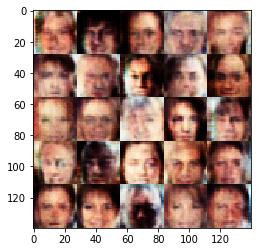

Epoch 0/1... Discriminator Loss: 1.4630... Generator Loss: 0.8419
Epoch 0/1... Discriminator Loss: 1.3873... Generator Loss: 0.7955
Epoch 0/1... Discriminator Loss: 0.9632... Generator Loss: 1.3637
Epoch 0/1... Discriminator Loss: 1.4724... Generator Loss: 1.2566
Epoch 0/1... Discriminator Loss: 1.3596... Generator Loss: 0.5566
Epoch 0/1... Discriminator Loss: 0.9529... Generator Loss: 1.0665
Epoch 0/1... Discriminator Loss: 1.4822... Generator Loss: 1.1474
Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.8890
Epoch 0/1... Discriminator Loss: 1.3787... Generator Loss: 0.9693
Epoch 0/1... Discriminator Loss: 1.3388... Generator Loss: 0.7200


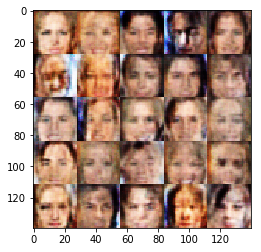

Epoch 0/1... Discriminator Loss: 1.5203... Generator Loss: 0.4806
Epoch 0/1... Discriminator Loss: 1.3297... Generator Loss: 0.8720
Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.7307
Epoch 0/1... Discriminator Loss: 1.2877... Generator Loss: 1.0181
Epoch 0/1... Discriminator Loss: 1.2704... Generator Loss: 0.8477
Epoch 0/1... Discriminator Loss: 1.3484... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.4504... Generator Loss: 0.8857
Epoch 0/1... Discriminator Loss: 1.2443... Generator Loss: 0.9579
Epoch 0/1... Discriminator Loss: 1.4193... Generator Loss: 0.6213
Epoch 0/1... Discriminator Loss: 1.4536... Generator Loss: 0.9933


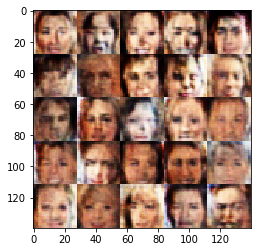

Epoch 0/1... Discriminator Loss: 1.6658... Generator Loss: 0.3709
Epoch 0/1... Discriminator Loss: 0.9488... Generator Loss: 1.2715
Epoch 0/1... Discriminator Loss: 1.4432... Generator Loss: 0.7401
Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 0.9567
Epoch 0/1... Discriminator Loss: 1.3815... Generator Loss: 1.0107
Epoch 0/1... Discriminator Loss: 1.3998... Generator Loss: 0.7738
Epoch 0/1... Discriminator Loss: 1.2622... Generator Loss: 1.0706
Epoch 0/1... Discriminator Loss: 1.2738... Generator Loss: 0.7967
Epoch 0/1... Discriminator Loss: 1.2517... Generator Loss: 0.7738
Epoch 0/1... Discriminator Loss: 1.6912... Generator Loss: 0.3521


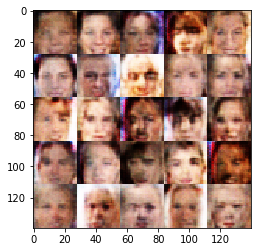

Epoch 0/1... Discriminator Loss: 1.2908... Generator Loss: 0.7901
Epoch 0/1... Discriminator Loss: 1.1595... Generator Loss: 1.3393
Epoch 0/1... Discriminator Loss: 1.2168... Generator Loss: 0.9317
Epoch 0/1... Discriminator Loss: 1.4829... Generator Loss: 0.7660
Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.9595
Epoch 0/1... Discriminator Loss: 1.2545... Generator Loss: 1.1599
Epoch 0/1... Discriminator Loss: 1.2719... Generator Loss: 0.8144
Epoch 0/1... Discriminator Loss: 1.1140... Generator Loss: 0.9539
Epoch 0/1... Discriminator Loss: 1.3325... Generator Loss: 1.2556
Epoch 0/1... Discriminator Loss: 1.2546... Generator Loss: 1.2154


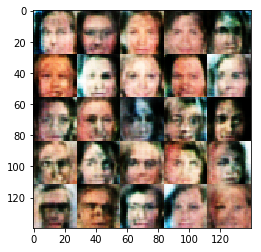

Epoch 0/1... Discriminator Loss: 1.1831... Generator Loss: 0.6969
Epoch 0/1... Discriminator Loss: 1.4763... Generator Loss: 0.7615
Epoch 0/1... Discriminator Loss: 1.3936... Generator Loss: 0.9225
Epoch 0/1... Discriminator Loss: 1.2873... Generator Loss: 0.8222
Epoch 0/1... Discriminator Loss: 1.3098... Generator Loss: 0.9787
Epoch 0/1... Discriminator Loss: 1.3136... Generator Loss: 0.8271
Epoch 0/1... Discriminator Loss: 1.2623... Generator Loss: 1.2878
Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 0.9940
Epoch 0/1... Discriminator Loss: 1.2576... Generator Loss: 1.0462
Epoch 0/1... Discriminator Loss: 1.6233... Generator Loss: 1.5405


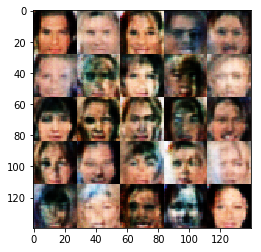

Epoch 0/1... Discriminator Loss: 1.2434... Generator Loss: 0.8780
Epoch 0/1... Discriminator Loss: 1.3362... Generator Loss: 0.7924
Epoch 0/1... Discriminator Loss: 1.3000... Generator Loss: 0.7799
Epoch 0/1... Discriminator Loss: 1.2516... Generator Loss: 0.9206
Epoch 0/1... Discriminator Loss: 1.4057... Generator Loss: 0.6597
Epoch 0/1... Discriminator Loss: 1.5116... Generator Loss: 0.8525
Epoch 0/1... Discriminator Loss: 1.2966... Generator Loss: 0.9862
Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.9691
Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 1.1466
Epoch 0/1... Discriminator Loss: 1.4216... Generator Loss: 0.5771


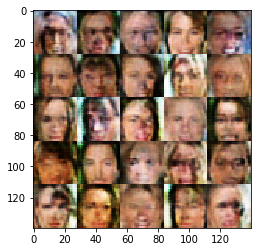

Epoch 0/1... Discriminator Loss: 1.2491... Generator Loss: 0.8633
Epoch 0/1... Discriminator Loss: 1.2478... Generator Loss: 0.8135
Epoch 0/1... Discriminator Loss: 1.3907... Generator Loss: 1.2565
Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.7230
Epoch 0/1... Discriminator Loss: 1.3143... Generator Loss: 0.9256
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 1.4471... Generator Loss: 0.6089
Epoch 0/1... Discriminator Loss: 1.2090... Generator Loss: 1.3029
Epoch 0/1... Discriminator Loss: 1.3121... Generator Loss: 1.0339
Epoch 0/1... Discriminator Loss: 1.5253... Generator Loss: 1.2950


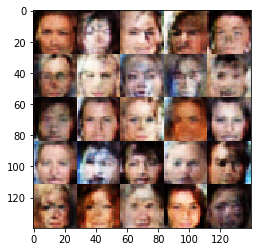

Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 1.0829
Epoch 0/1... Discriminator Loss: 1.3419... Generator Loss: 0.6820
Epoch 0/1... Discriminator Loss: 1.5039... Generator Loss: 1.2140
Epoch 0/1... Discriminator Loss: 1.1119... Generator Loss: 1.1920
Epoch 0/1... Discriminator Loss: 1.3049... Generator Loss: 0.7778
Epoch 0/1... Discriminator Loss: 1.3420... Generator Loss: 0.7969
Epoch 0/1... Discriminator Loss: 1.4077... Generator Loss: 0.6550
Epoch 0/1... Discriminator Loss: 1.3933... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 1.2210... Generator Loss: 1.0142
Epoch 0/1... Discriminator Loss: 1.2538... Generator Loss: 1.0721


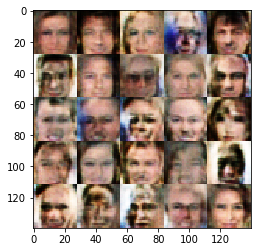

Epoch 0/1... Discriminator Loss: 1.2854... Generator Loss: 0.8642
Epoch 0/1... Discriminator Loss: 1.2067... Generator Loss: 1.0170
Epoch 0/1... Discriminator Loss: 1.3029... Generator Loss: 0.7939
Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 0.9509
Epoch 0/1... Discriminator Loss: 1.2825... Generator Loss: 0.9129
Epoch 0/1... Discriminator Loss: 1.3358... Generator Loss: 0.7366
Epoch 0/1... Discriminator Loss: 1.2837... Generator Loss: 0.6783
Epoch 0/1... Discriminator Loss: 1.3452... Generator Loss: 0.9391
Epoch 0/1... Discriminator Loss: 1.3990... Generator Loss: 0.8762
Epoch 0/1... Discriminator Loss: 1.2425... Generator Loss: 0.8962


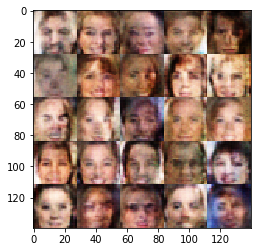

Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.7854
Epoch 0/1... Discriminator Loss: 0.9920... Generator Loss: 1.0474
Epoch 0/1... Discriminator Loss: 1.2673... Generator Loss: 0.9108
Epoch 0/1... Discriminator Loss: 1.2576... Generator Loss: 1.0223
Epoch 0/1... Discriminator Loss: 1.3950... Generator Loss: 0.8840
Epoch 0/1... Discriminator Loss: 1.3799... Generator Loss: 0.7009
Epoch 0/1... Discriminator Loss: 1.3049... Generator Loss: 0.7501
Epoch 0/1... Discriminator Loss: 1.3400... Generator Loss: 0.8123
Epoch 0/1... Discriminator Loss: 1.3792... Generator Loss: 0.6664
Epoch 0/1... Discriminator Loss: 1.2084... Generator Loss: 0.8566


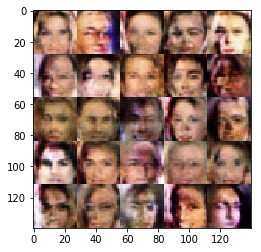

Epoch 0/1... Discriminator Loss: 1.2942... Generator Loss: 0.8613
Epoch 0/1... Discriminator Loss: 1.2989... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.3119... Generator Loss: 0.7257
Epoch 0/1... Discriminator Loss: 1.3330... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 1.2227... Generator Loss: 1.6018
Epoch 0/1... Discriminator Loss: 1.4431... Generator Loss: 1.6409
Epoch 0/1... Discriminator Loss: 1.3372... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 1.2787... Generator Loss: 0.8310
Epoch 0/1... Discriminator Loss: 1.3275... Generator Loss: 1.2132
Epoch 0/1... Discriminator Loss: 1.8794... Generator Loss: 2.0893


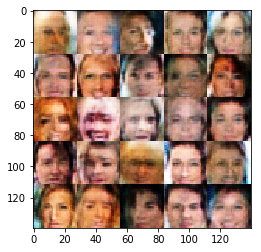

Epoch 0/1... Discriminator Loss: 1.6487... Generator Loss: 0.7869
Epoch 0/1... Discriminator Loss: 1.3737... Generator Loss: 0.6995
Epoch 0/1... Discriminator Loss: 1.3063... Generator Loss: 0.9295
Epoch 0/1... Discriminator Loss: 1.2370... Generator Loss: 0.9683
Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.8718
Epoch 0/1... Discriminator Loss: 1.1720... Generator Loss: 0.7553
Epoch 0/1... Discriminator Loss: 1.3228... Generator Loss: 1.0251
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 0.7301
Epoch 0/1... Discriminator Loss: 1.2321... Generator Loss: 0.9176
Epoch 0/1... Discriminator Loss: 1.3038... Generator Loss: 0.7482


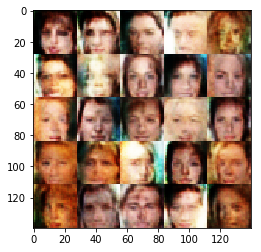

Epoch 0/1... Discriminator Loss: 1.3015... Generator Loss: 0.8483
Epoch 0/1... Discriminator Loss: 1.3178... Generator Loss: 0.7267
Epoch 0/1... Discriminator Loss: 1.2208... Generator Loss: 1.1202
Epoch 0/1... Discriminator Loss: 1.4527... Generator Loss: 0.9142
Epoch 0/1... Discriminator Loss: 1.2618... Generator Loss: 0.9565
Epoch 0/1... Discriminator Loss: 1.1153... Generator Loss: 1.2713
Epoch 0/1... Discriminator Loss: 1.3739... Generator Loss: 0.7208
Epoch 0/1... Discriminator Loss: 1.3365... Generator Loss: 1.4542
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 1.2714
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 0.8065


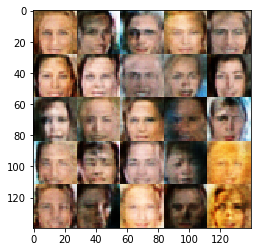

Epoch 0/1... Discriminator Loss: 1.3688... Generator Loss: 0.5460
Epoch 0/1... Discriminator Loss: 1.4177... Generator Loss: 1.3570
Epoch 0/1... Discriminator Loss: 1.2022... Generator Loss: 1.0915
Epoch 0/1... Discriminator Loss: 1.4425... Generator Loss: 1.1954
Epoch 0/1... Discriminator Loss: 1.2840... Generator Loss: 0.9352
Epoch 0/1... Discriminator Loss: 1.3540... Generator Loss: 0.6810
Epoch 0/1... Discriminator Loss: 1.1831... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 1.0629... Generator Loss: 0.9858
Epoch 0/1... Discriminator Loss: 1.5910... Generator Loss: 1.5027
Epoch 0/1... Discriminator Loss: 1.2852... Generator Loss: 0.8870


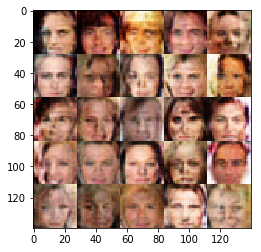

Epoch 0/1... Discriminator Loss: 1.2476... Generator Loss: 0.7985
Epoch 0/1... Discriminator Loss: 1.6951... Generator Loss: 1.4966
Epoch 0/1... Discriminator Loss: 1.2334... Generator Loss: 0.6374
Epoch 0/1... Discriminator Loss: 1.3378... Generator Loss: 0.8451
Epoch 0/1... Discriminator Loss: 1.2062... Generator Loss: 0.8085
Epoch 0/1... Discriminator Loss: 1.1758... Generator Loss: 0.7411
Epoch 0/1... Discriminator Loss: 1.3193... Generator Loss: 0.6138
Epoch 0/1... Discriminator Loss: 1.1667... Generator Loss: 1.2462
Epoch 0/1... Discriminator Loss: 1.3451... Generator Loss: 0.8548
Epoch 0/1... Discriminator Loss: 1.2992... Generator Loss: 0.6338


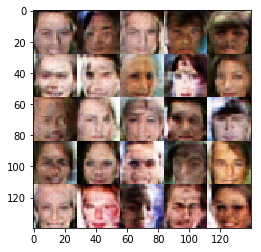

Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.9152
Epoch 0/1... Discriminator Loss: 1.3606... Generator Loss: 0.7580
Epoch 0/1... Discriminator Loss: 1.2794... Generator Loss: 0.8833
Epoch 0/1... Discriminator Loss: 1.3100... Generator Loss: 0.7310
Epoch 0/1... Discriminator Loss: 1.3815... Generator Loss: 0.7437
Epoch 0/1... Discriminator Loss: 1.4111... Generator Loss: 0.5334
Epoch 0/1... Discriminator Loss: 1.2038... Generator Loss: 0.9561
Epoch 0/1... Discriminator Loss: 1.0908... Generator Loss: 1.1701
Epoch 0/1... Discriminator Loss: 1.2745... Generator Loss: 0.6946
Epoch 0/1... Discriminator Loss: 1.1096... Generator Loss: 0.9223


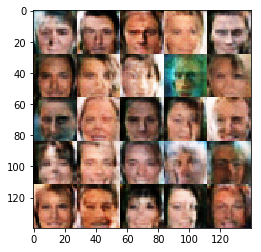

Epoch 0/1... Discriminator Loss: 1.2228... Generator Loss: 0.9809
Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 1.0264
Epoch 0/1... Discriminator Loss: 1.3460... Generator Loss: 0.8816
Epoch 0/1... Discriminator Loss: 1.3954... Generator Loss: 0.5220
Epoch 0/1... Discriminator Loss: 1.2802... Generator Loss: 0.9304
Epoch 0/1... Discriminator Loss: 1.2868... Generator Loss: 1.0892
Epoch 0/1... Discriminator Loss: 1.7346... Generator Loss: 0.3454
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.9992
Epoch 0/1... Discriminator Loss: 1.2685... Generator Loss: 0.7562
Epoch 0/1... Discriminator Loss: 1.2383... Generator Loss: 0.9658


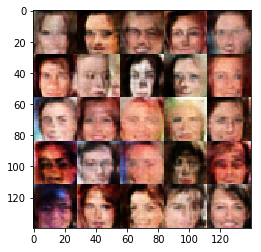

Epoch 0/1... Discriminator Loss: 1.2831... Generator Loss: 0.6899
Epoch 0/1... Discriminator Loss: 1.2571... Generator Loss: 0.8622
Epoch 0/1... Discriminator Loss: 1.2813... Generator Loss: 0.8149
Epoch 0/1... Discriminator Loss: 1.1601... Generator Loss: 0.7033
Epoch 0/1... Discriminator Loss: 1.3042... Generator Loss: 0.8394
Epoch 0/1... Discriminator Loss: 1.2611... Generator Loss: 1.1423
Epoch 0/1... Discriminator Loss: 1.3333... Generator Loss: 0.7015
Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 1.0038
Epoch 0/1... Discriminator Loss: 1.1973... Generator Loss: 1.0778
Epoch 0/1... Discriminator Loss: 1.3047... Generator Loss: 0.5831


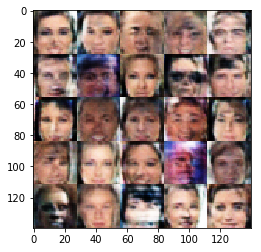

Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.8906
Epoch 0/1... Discriminator Loss: 1.3221... Generator Loss: 0.9188
Epoch 0/1... Discriminator Loss: 1.3620... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.3554... Generator Loss: 0.5870
Epoch 0/1... Discriminator Loss: 1.3319... Generator Loss: 0.8120
Epoch 0/1... Discriminator Loss: 1.2262... Generator Loss: 1.0563
Epoch 0/1... Discriminator Loss: 1.2024... Generator Loss: 0.9560
Epoch 0/1... Discriminator Loss: 1.2449... Generator Loss: 0.7067
Epoch 0/1... Discriminator Loss: 1.4332... Generator Loss: 1.1307
Epoch 0/1... Discriminator Loss: 1.2409... Generator Loss: 0.8927


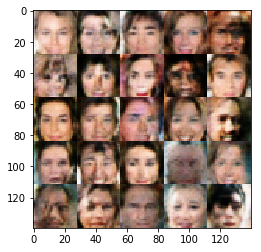

Epoch 0/1... Discriminator Loss: 1.0745... Generator Loss: 0.8443
Epoch 0/1... Discriminator Loss: 1.3477... Generator Loss: 1.2932
Epoch 0/1... Discriminator Loss: 1.2624... Generator Loss: 0.7358
Epoch 0/1... Discriminator Loss: 1.2359... Generator Loss: 0.6852
Epoch 0/1... Discriminator Loss: 1.1295... Generator Loss: 0.8994
Epoch 0/1... Discriminator Loss: 1.5014... Generator Loss: 0.4687
Epoch 0/1... Discriminator Loss: 1.2157... Generator Loss: 0.7280
Epoch 0/1... Discriminator Loss: 1.2274... Generator Loss: 0.9186
Epoch 0/1... Discriminator Loss: 1.3785... Generator Loss: 1.4810
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 1.1261


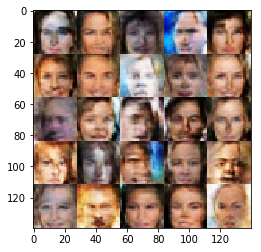

Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.6769
Epoch 0/1... Discriminator Loss: 1.1666... Generator Loss: 1.1349
Epoch 0/1... Discriminator Loss: 1.2007... Generator Loss: 1.0481
Epoch 0/1... Discriminator Loss: 1.2400... Generator Loss: 0.7193
Epoch 0/1... Discriminator Loss: 1.3442... Generator Loss: 0.6499
Epoch 0/1... Discriminator Loss: 1.3235... Generator Loss: 0.6133
Epoch 0/1... Discriminator Loss: 1.2932... Generator Loss: 0.7017
Epoch 0/1... Discriminator Loss: 1.2818... Generator Loss: 1.0253
Epoch 0/1... Discriminator Loss: 1.2880... Generator Loss: 0.9814
Epoch 0/1... Discriminator Loss: 1.3331... Generator Loss: 0.9934


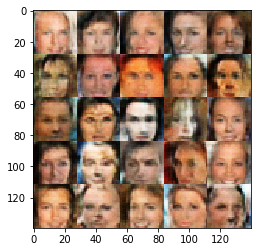

Epoch 0/1... Discriminator Loss: 1.1740... Generator Loss: 0.8512
Epoch 0/1... Discriminator Loss: 1.2559... Generator Loss: 0.7097
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 1.3004
Epoch 0/1... Discriminator Loss: 1.1793... Generator Loss: 0.9932
Epoch 0/1... Discriminator Loss: 1.2893... Generator Loss: 0.8016
Epoch 0/1... Discriminator Loss: 1.2879... Generator Loss: 0.7182
Epoch 0/1... Discriminator Loss: 1.2961... Generator Loss: 1.4644
Epoch 0/1... Discriminator Loss: 1.1171... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 1.0483... Generator Loss: 1.1012
Epoch 0/1... Discriminator Loss: 1.3644... Generator Loss: 0.5994


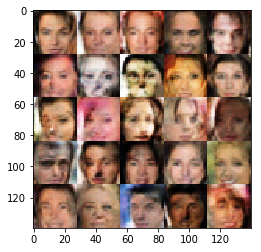

Epoch 0/1... Discriminator Loss: 1.1381... Generator Loss: 0.8123
Epoch 0/1... Discriminator Loss: 1.0911... Generator Loss: 1.3023
Epoch 0/1... Discriminator Loss: 1.2409... Generator Loss: 0.9592
Epoch 0/1... Discriminator Loss: 1.1422... Generator Loss: 0.8438
Epoch 0/1... Discriminator Loss: 1.0701... Generator Loss: 1.0127
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 0.7040
Epoch 0/1... Discriminator Loss: 1.2907... Generator Loss: 0.6204
Epoch 0/1... Discriminator Loss: 1.5711... Generator Loss: 0.4141
Epoch 0/1... Discriminator Loss: 1.2467... Generator Loss: 0.7202
Epoch 0/1... Discriminator Loss: 1.2873... Generator Loss: 0.9803


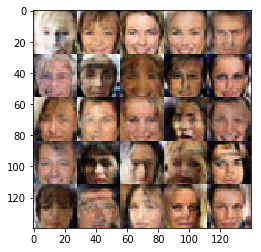

Epoch 0/1... Discriminator Loss: 1.3745... Generator Loss: 0.5187
Epoch 0/1... Discriminator Loss: 0.9716... Generator Loss: 1.3489
Epoch 0/1... Discriminator Loss: 1.2037... Generator Loss: 0.7416
Epoch 0/1... Discriminator Loss: 1.2153... Generator Loss: 1.1904
Epoch 0/1... Discriminator Loss: 1.1210... Generator Loss: 1.2573
Epoch 0/1... Discriminator Loss: 1.3400... Generator Loss: 0.6674


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.